# Подготовка

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

from drive.MyDrive.kursach import helpers
path = 'drive/MyDrive/kursach/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import copy
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn import model_selection
import torch
from torch import nn
from torch.utils import data

In [ ]:
rand = 51
np.random.seed(rand)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
im_medseg, mk_medseg, im_radio, mk_radio = helpers.load_datasets(path, size=(256, 256))

Added drive/MyDrive/kursach/raw-data-kaggle/images_medseg.npy, shape (1, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_medseg.npy, shape (4, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/images_radiopedia.npy, shape (1, 829, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_radiopedia.npy, shape (4, 829, 256, 256)


In [ ]:
gc.collect()

74

# Основные классы и функции

Напишем основную структуру и базовую нейросеть на основе Unet. 

In [ ]:
class Dataset(data.Dataset):
  def __init__(self, X, y):
    self.X = torch.from_numpy(X.astype(np.float32)).to(device)
    self.X = self.X.reshape(-1, 1, X.shape[1], X.shape[2])
    self.y = torch.from_numpy(y.astype(np.int64)).to(device)

  def __len__(self):
    return self.y.shape[0]

  def __getitem__(self, i):
    return self.X[i], self.y[i]

def get_loader(dataset, batch=64):
  return torch.utils.data.DataLoader(dataset, batch_size=batch)

def prepare_datasets(X, y):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
      X, y, train_size=0.8, random_state=rand)
  train = Dataset(X_train, y_train)
  test = Dataset(X_test, y_test)
  return train, test

In [ ]:
class Network:
  def __init__(self, model, loss):
    self.model = model.to(device)
    self.loss = loss
    self.optim = torch.optim.Adam(self.model.parameters())
    self.loss_history = []

  def fit(self, data, epochs=50, verbose=False):
    data = get_loader(data)
    for i in range(epochs):
      total_loss = 0
      for X, y in data:
        pred = self.model(X)
        loss = self.loss(pred, y)
        total_loss += loss.detach().to('cpu').item()

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

      if verbose:
        print(f'Epoch {i}, loss {total_loss}')
      self.loss_history.append(total_loss)

  def test(self, data, metric, *args):
    data = get_loader(data)
    size = len(data.dataset)
    num_batches = len(data)
    total_metric = 0.

    with torch.no_grad():
      for X, y in data:
        pred = self.model(X).argmax(1)
        if metric == 'accuracy':
          total_metric += self._accuracy(pred, y)
        elif metric == 'iou':
          total_metric += self._iou(pred, y, args[0])

    if metric == 'accuracy':
      total_metric /= size
    elif metric == 'iou':
      total_metric /= num_batches

    return total_metric

  def _accuracy(self, y_pred, y_true):
    im_size = y_pred.shape[1] * y_pred.shape[2]
    return (y_pred == y_true).type(torch.float).sum().item() / im_size

  def _iou(self, y_pred, y_true, class_label):
    y_pred = y_pred == class_label
    y_true = y_true == class_label
    intersection = y_pred & y_true
    union = y_pred | y_true
    return intersection.type(torch.float).sum().item() / union.type(torch.float).sum().item()

In [ ]:
def create_network(n_classes):
  return Network(smp.Unet(in_channels=1, classes=n_classes, activation='softmax'),
                 nn.CrossEntropyLoss())

# Простейшая нейросеть

Научим нашу нейросеть опрределять, где легкие, а где фон.

In [ ]:
X = np.concatenate((im_medseg[0], im_radio[0]), axis=0)
y = np.concatenate((mk_medseg, mk_radio), axis=1)[3]
y = np.where(y, 0, 1)

X.shape, y.shape

((929, 256, 256), (929, 256, 256))

In [ ]:
train, test = prepare_datasets(X, y)

In [ ]:
model = create_network(2)

In [ ]:
model.fit(train, epochs=20, verbose=True)

Epoch 0, loss 5.91253736615181
Epoch 1, loss 4.30148920416832
Epoch 2, loss 4.031476527452469
Epoch 3, loss 3.9367026686668396
Epoch 4, loss 3.8965523540973663
Epoch 5, loss 3.87527534365654
Epoch 6, loss 3.862126737833023
Epoch 7, loss 3.852921813726425
Epoch 8, loss 3.8465239703655243
Epoch 9, loss 3.841261476278305
Epoch 10, loss 3.8348615765571594
Epoch 11, loss 3.8288127183914185
Epoch 12, loss 3.82467183470726
Epoch 13, loss 3.8208595514297485
Epoch 14, loss 3.818980723619461
Epoch 15, loss 3.8163295090198517
Epoch 16, loss 3.8137539327144623
Epoch 17, loss 3.81147763133049
Epoch 18, loss 3.8090496361255646
Epoch 19, loss 3.807674139738083


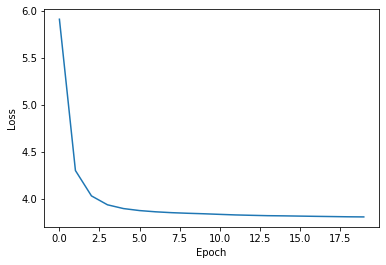

In [ ]:
helpers.plot_loss(model)

In [ ]:
model.test(test, 'accuracy')

0.9954217069892473

In [ ]:
model.test(test, 'iou', 1)

0.9731696558524363

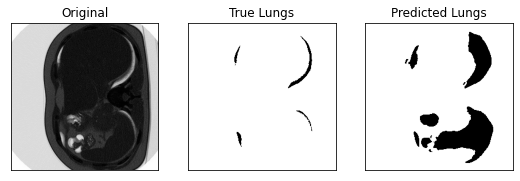

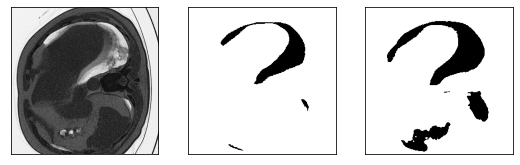

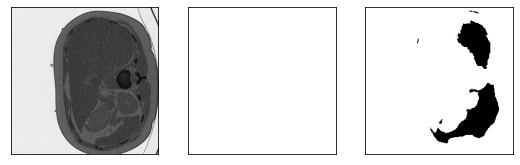

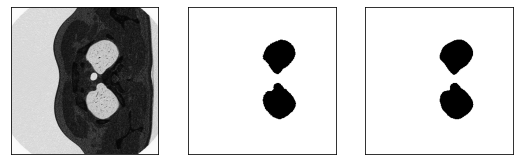

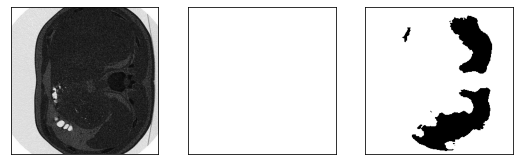

In [ ]:
for i in range(5):
  sample, true_answer = test[i]
  pred_answer = model.model(sample.reshape(1, 1, sample.shape[1], -1)).argmax(1)
  images = [sample[0], true_answer, pred_answer[0]]
  images = [im.cpu().detach().numpy() for im in images]
  titles = ['Original', 'True Lungs', 'Predicted Lungs'] if i == 0 else None
  helpers.show_im_row(np.array(images), size=3, titles=titles)

Результат, в целом, хороший, хотя и задача здесь стояла простая. Попробуем проделать то же для четырех классов.

# Классифицируем по четырем классам

In [ ]:
X = np.concatenate((im_medseg[0], im_radio[0]), axis=0)
y = np.concatenate((mk_medseg, mk_radio), axis=1)
y = y.argmax(0)
y.shape

(929, 256, 256)

In [ ]:
train, test = prepare_datasets(X, y)
model = create_network(4)

In [ ]:
model.fit(train, epochs=20, verbose=True)

Epoch 0, loss 14.30937647819519
Epoch 1, loss 11.094976365566254
Epoch 2, loss 9.765286207199097
Epoch 3, loss 9.389342904090881
Epoch 4, loss 9.269158124923706
Epoch 5, loss 9.21421879529953
Epoch 6, loss 9.188944458961487
Epoch 7, loss 9.17965418100357
Epoch 8, loss 9.151700258255005
Epoch 9, loss 9.141826748847961
Epoch 10, loss 9.130755722522736
Epoch 11, loss 9.125205338001251
Epoch 12, loss 9.117879807949066
Epoch 13, loss 9.115870535373688
Epoch 14, loss 9.112201392650604
Epoch 15, loss 9.107270240783691
Epoch 16, loss 9.099853754043579
Epoch 17, loss 9.093416392803192
Epoch 18, loss 9.086716949939728
Epoch 19, loss 9.081256330013275


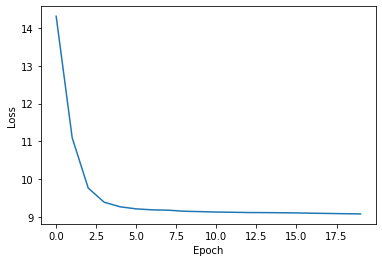

In [ ]:
helpers.plot_loss(model)

In [ ]:
model.test(test, 'accuracy')

0.9870434012464298

In [ ]:
for i in range(4):
  print(helpers.LABELS[i], 'IoU:', model.test(test, 'iou', i))

Ground Glass IoU: 0.6585816976259334
Consolidation IoU: 0.0002719110282589966
Lungs Other IoU: 0.9357099345079588
Background IoU: 0.9929862459142192


Видим, что модель научилась хорошо находить самые "простые" классы - легкие и фон. А вот с классами, которые нас интересуют больше всего, имеются проблемы.

In [ ]:
label_pairs = [('True ' + label, 'Predicted ' + label)
               for label in helpers.LABELS]
# flatten label pairs
labels = [label for pair in label_pairs for label in pair]

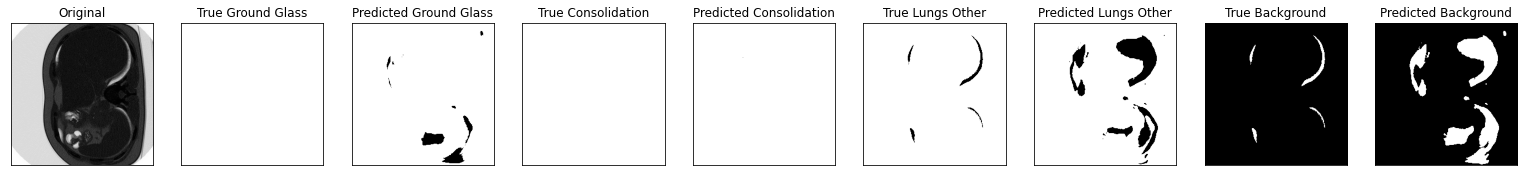

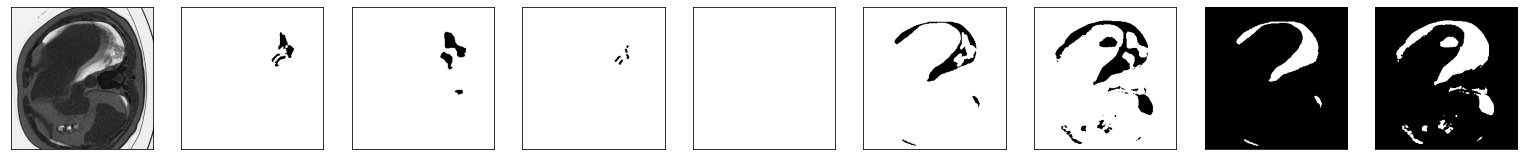

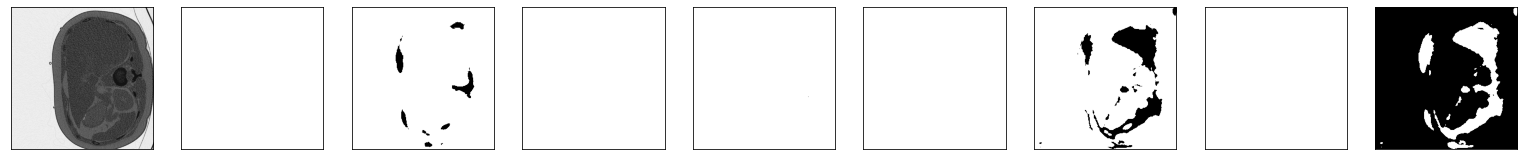

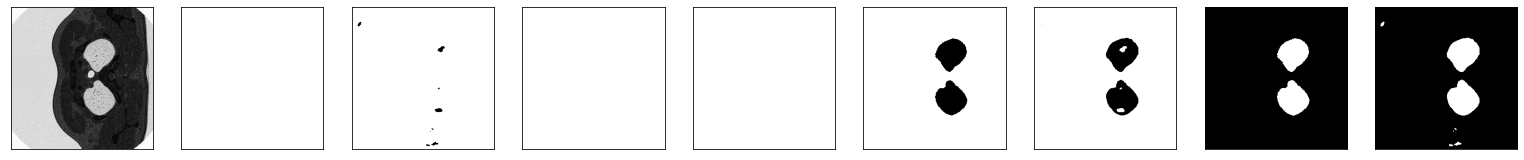

In [ ]:
for i in range(4):
  sample, true_answer = test[i]
  pred_answer = model.model(sample.reshape(1, 1, sample.shape[1], -1)).argmax(1)
  images = [sample[0]]
  for j in range(4):
    images += [true_answer == j, (pred_answer == j)[0]]
  images = [im.cpu().detach().numpy() for im in images]
  titles = ['Original'] + labels if i == 0 else None
  helpers.show_im_row(np.array(images), size=3, titles=titles)